# Objective

**Given Problem statement:** 
To retrieve relevant database images to a given query image (ie, the model should retrieve database images containing the same landmark as the query)

**What this notebook explores:**
This notebook looks at the datasets and the structure provided along with an EDA pipeline to explore this.

Lets jump right in !!!

# References
1. https://www.kaggle.com/seriousran/google-landmark-retrieval-2020-eda
2. https://www.kaggle.com/c/landmark-retrieval-2020/discussion/163390

# Understanding structure

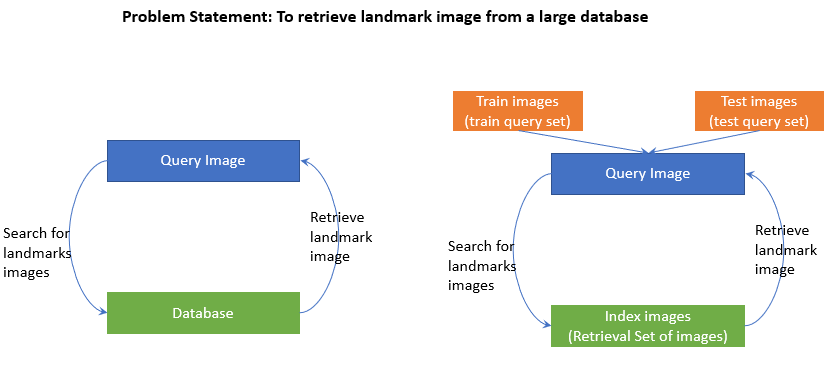

# Lets understand the given data

### Lets being by importing neccessary packages

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import glob
import matplotlib.pyplot as plt
import random
import cv2

### Setting important directories

In [ ]:
root_dir = "/kaggle/input/landmark-retrieval-2020/"
train_dir = os.path.join(root_dir,"train/")
test_dir = os.path.join(root_dir,"test/")
index_dir = os.path.join(root_dir,"index/")
train_csv = os.path.join(root_dir,"train.csv")
landmark_id_mapping_csv = "/kaggle/input/glrc2020-landmarkid-mapping/glrc2020_landmarkid_mapping.csv"

## Now lets examine traincsv

In [ ]:
df_train = pd.read_csv(train_csv)

#### Checking for null values => None found

In [ ]:
df_train.loc[df_train['id'].isnull(),:]

#### Its given image_ids are uniques, still lets check
#### What we also have here is: each image has only one landmark

#### Checking for null values with landmark_id column:

In [ ]:
df_train.loc[df_train['landmark_id'].isnull(),:]

No null values found here as well. So we are clear here

Now lets match with the image data we have in the train folder

In [ ]:
# of images in train folder => train query images
sum_train=0
for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        if ".jpg" in filename:
            sum_train= sum_train + 1
print("Number of images in train folder = {}".format(sum_train))

In [ ]:
# of images in test folder => test query images
sum_test=0
for dirname, _, filenames in os.walk(test_dir):
    for filename in filenames:
        if ".jpg" in filename:
            sum_test= sum_test + 1
print("Number of images in test folder = {}".format(sum_test))

In [ ]:
# of images in index folder
# The index images are the images you retrieve. 
# i.e. if the "query" test set image is a picture of the Taj Mahal, 
# you are retrieving the images in the index set that you believe match the same landmark.
sum_index=0
for dirname, _, filenames in os.walk(index_dir):
    for filename in filenames:
        if ".jpg" in filename:
            sum_index= sum_index + 1
print("Number of images in index folder = {}".format(sum_index))

### As we have seen the folder structure in detail, lets deep-dive into landmark 

In [ ]:
# Histogram distribution for landmark_ids
fig, ax =plt.subplots(figsize=(8,8))
ax.hist(df_train['landmark_id'],bins=1000,density=False)
plt.show()

So we can see somes spikes in the distribution, so there is a possibility that some landmark images might be occurring more frequently. We will look at that, once we analyze the train, test & index folders

In [ ]:
xdf = pd.DataFrame(df_train['landmark_id'].value_counts(dropna=False)).reset_index(inplace=False)
xdf.columns = ['landmark_id','count']

In [ ]:
xdf.boxplot(column='count')

In [ ]:
xdf.loc[xdf['count']<1000,:].boxplot(column='count')

In [ ]:
#fig = plt.figure()
#ax = fig.add_subplot(111)
fig, ax =plt.subplots(nrows=2,ncols=2,figsize=(16,8),squeeze=False)
ax[0,0].scatter(xdf['landmark_id'],xdf['count'],c=xdf['landmark_id'],s=50)
ax[0,0].tick_params(axis='x',rotation=45)
ax[0,0].title.set_text('scatter plot: landmark_id v/s count ')

filterdf = xdf.loc[xdf['count']<1000,:]

ax[0,1].scatter(filterdf['landmark_id'],filterdf['count'],c=filterdf['landmark_id'],s=50)
ax[0,1].tick_params(axis='x',rotation=45)
ax[0,1].title.set_text('scatter plot: landmark_id v/s count ')

filterdf = xdf.loc[xdf['count']<500,:]

ax[1,0].scatter(filterdf['landmark_id'],filterdf['count'],c=filterdf['landmark_id'],s=50)
ax[1,0].tick_params(axis='x',rotation=45)
ax[1,0].title.set_text('scatter plot: landmark_id v/s count ')


filterdf = xdf.loc[xdf['count']<100,:]

ax[1,1].scatter(filterdf['landmark_id'],filterdf['count'],c=filterdf['landmark_id'],s=50)
ax[1,1].tick_params(axis='x',rotation=45)
ax[1,1].title.set_text('scatter plot: landmark_id v/s count ')

fig.tight_layout(pad=3.0)

plt.show()

In [ ]:
# No. of landmarks which are predominant
xdf.shape[0]-xdf.loc[xdf['count']<1000,:].shape[0]

For all the above visualizations, we can infer:

i.) 7 images are clear outliers i.e. there are 7 landmarks which are occuring at a higher frequency i.e. more than 1000 times in the given set of 1580470 image_ids

ii.) then we have a moderate number in the range of above 100

iii.) Majority of landmark sightings are in the range 1-100


Lets look at these outliers landmarks - 
To do so, we will need to bring a dataset referred in the competition and also in this discussion
https://www.kaggle.com/c/landmark-retrieval-2020/discussion/163390

In [ ]:
landmark_mapping_df = pd.read_csv(landmark_id_mapping_csv)
landmark_mapping ={}
for l_id, cat in zip(list(landmark_mapping_df['landmark_id']),list(landmark_mapping_df['category'])):
    landmark_mapping[l_id]=cat

In [ ]:
for l_id in list(xdf.loc[xdf['count']>1000,:]['landmark_id']):
    print(l_id)
    print(landmark_mapping[l_id])

#### Lets take an example of landmark_id = 20409, which as per the mapping is Noraduz Cemetery present in Armenia

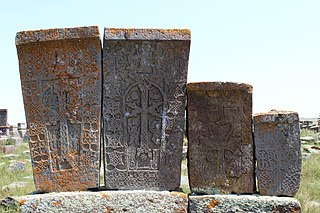

#### Lets filter dataframe wrt this landmark_id and check whether images within train image directory actually contain these landmarks.. lets look at 9 images

In [ ]:
nc_df = df_train[df_train['landmark_id']==20409]

fig, ax = plt.subplots(3, 3, figsize=(16, 8))
for r in range(3):
    for c in range(3):
        img_id = random.choice(list(nc_df['id']))
        img_path = os.path.join(os.path.join(os.path.join(os.path.join(train_dir,img_id[0]),img_id[1]),img_id[2]),img_id)+".jpg"
        img = cv2.imread(img_path)
        ax[r,c].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[r,c].set_axis_off()

So we have been able to successfully able to correlate multuple datsets. Basis our exploration we have understood certain landmarks are more predominant in the image set. Moreover, we also understand spatial orientation among others will play an important role also discussed in this thread:

https://www.kaggle.com/c/landmark-retrieval-2020/discussion/163287